# Train Model



## Set parameters that will control the execution

In [1]:
DATA_DIR = "../_DATA/CarND/p3_behavioral_cloning/set_000/"
image_dir = "IMG/"
driving_data_csv = "driving_log_original.csv"
YIELD_BATCH_SIZE = 128
RUN_EPOCHS = 3 

should_retrain_existing_model = False
SAVED_MODEL = "model_epoch_5_val_acc_0.543157893482.h5"
RUN_EPOCHS_PREVIOUSLY = 0

In [2]:
import DataHelper

Using TensorFlow backend.


# Allocate only a fraction of memory to TensorFlow GPU process

In [3]:
# https://github.com/aymericdamien/TensorFlow-Examples/issues/38#issuecomment-265599695
import tensorflow as tf

# Running out of GPU memory on Mac
# InternalError: Dst tensor is not initialized.
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.8) # try range from 0.3 to 0.9
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True, gpu_options=gpu_options))

#### Show available CPU and GPU(s)
from tensorflow.python.client import device_lib
def get_available_CPU_GPU():
    devices = device_lib.list_local_devices()
    #return [x.name for x in devices if x.device_type == 'CPU']
    return [x.name for x in devices ]

print(get_available_CPU_GPU())

['/cpu:0']


# Fetch data from CSV file

In [4]:
from  DataHelper import read_csv
csv_path = DATA_DIR + driving_data_csv
print("csv_path", csv_path)
headers, data = read_csv(DATA_DIR + driving_data_csv)

csv_path ../_DATA/CarND/p3_behavioral_cloning/set_000/driving_log_original.csv
Number of imported CSV rows: 8037


# Split data into training, testing and validation sets

In [5]:
from DataHelper import split_random
training, testing, validation = split_random(data, percent_train=75, percent_test=15) 

print("training", training.shape, type(training) )
print("testing", testing.shape, type(training))
print("validation", validation.shape, type(training))

percent_validation 10
training (6027, 7) <class 'numpy.ndarray'>
testing (1206, 7) <class 'numpy.ndarray'>
validation (803, 7) <class 'numpy.ndarray'>


# Fetch and visualize training steering angles

I would like to train a car on the set that has a nice bell curve distribution of values:
- I can drive the car on the track backwards
- I can flip each image (and value)

# Remove zero-steering angles from training set 

In [6]:
import numpy as np
from DataHelper import plot_histogram, get_steering_values, find_nearest

len(sample_set) 500
min_value -0.771834 max_value 1.0
spread 1.77183 in 178 bins


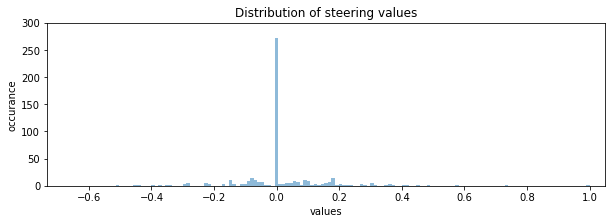

len(indexes_to_keep) 234
len(set_to_keep) 234
min_value -0.771834 max_value 1.0
spread 1.77183 in 178 bins


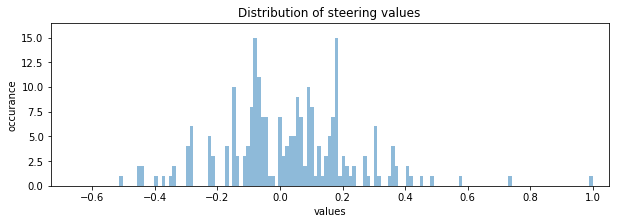

In [7]:
from remove_zero_angles import *
training, steering_angles = remove_zero_angles(training[0:500])

# Test method that extracts image names

In [8]:
from DataHelper import get_image_center_values

# TEST THE METHOD
image_names = get_image_center_values(training[0:10]) # process only first few
print("image count:", image_names.shape[0], "path:", image_names[1])

image count: 10 path: IMG/center_2016_12_01_13_43_09_548.jpg


# Create a list of image paths

In [9]:
from generator import build_image_paths

image_paths = build_image_paths(DATA_DIR, image_names)
print(image_paths[1]) 
print("found paths:", len(image_paths) ) 

../_DATA/CarND/p3_behavioral_cloning/set_000/IMG/center_2016_12_01_13_43_09_548.jpg
found paths: 10


# Read actual images

image_paths[2] ../_DATA/CarND/p3_behavioral_cloning/set_000/IMG/center_2016_12_01_13_35_09_047.jpg
training_features count 10
sample_image   (160, 320, 3)


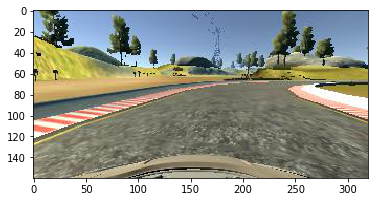

In [10]:
from generator import read_images

training_features = read_images(image_paths)

print ("image_paths[2]", image_paths[2] )
print ("training_features count", len(training_features) )

sample_image = training_features[2]
print ("sample_image  ", sample_image.shape)

import matplotlib.pyplot as plt
plt.imshow(sample_image) # cmap='gray' , cmap='rainbow'
plt.show()

#print(sample_image[0][0:15])

# Import Keras (layer above TensorFlow)

https://keras.io/layers/convolutional/

In [11]:
import cv2, numpy as np
from DataHelper import mean_pred, false_rates


# Build a Convolutional Neural Network

## Minimal Model

In [12]:
from model import * # my own model implementation, in the same directory

# Compile model (configure learning process)

Before training a model, you need to configure the learning process, which is done via the compile method.

In [13]:
model = get_custom_model()
model.summary()

# keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
optimizer="adam" # 'sgd' | 'rmsprop'
loss_function="mse" # | 'binary_crossentropy' | 'mse' | mean_squared_error | sparse_categorical_crossentropy
metrics_array=['accuracy'] # , mean_pred, false_rates
model.compile(optimizer, loss_function, metrics_array)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_1 (Cropping2D)    (None, 65, 320, 3)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 65, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 65, 320, 24)       1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 65, 320, 36)       21636     
_________________________________________________________________
flatten_1 (Flatten)          (None, 748800)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               74880100  
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
__________

# Replace model with one stored on disk

- If you replace the model, the INPUT dimetions have to be the same as these trained
- Name your models well

# Define yield Generator

In [ ]:
from generator import * # my own implementation of yield generator, same directory

train_generator = generator("training", training, DATA_DIR, YIELD_BATCH_SIZE )
validation_generator = generator("validation", validation, DATA_DIR, YIELD_BATCH_SIZE )

# Train (fit) the model agaist given labels

https://keras.io/models/sequential/


- initial_epoch: Epoch at which to start training (useful for resuming a previous training run)

- The semantics of the Keras 2 argument  `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. 
`steps_per_epoch` is the number of batches to draw from the generator at each epoch. Update your method calls accordingly.


In [ ]:
history = model.fit_generator(train_generator, 
                              epochs=RUN_EPOCHS, 
                              validation_steps = len(validation), #803 
                              validation_data = validation_generator, 
                              verbose = 1, 
                              steps_per_epoch = len(training) ) #2745

Epoch 1/3
233/234 [============================>.] - ETA: 13s - loss: 1.4641 - acc: 0.0013        

In [ ]:
# list all data in history
print(history.history.keys())

index = RUN_EPOCHS - 1

training_accuracy = str( history.history['acc'][index])
print("training_accuracy", training_accuracy)

training_error = str( history.history['loss'][index])
print("training_error", training_error)

validation_accuracy = str( history.history['val_acc'][index])
print("validation_accuracy", validation_accuracy)

validation_error = str( history.history['val_loss'][index])
print("validation_error", validation_error)

# Save the model

In [ ]:
# creates a HDF5 file '___.h5'
model.save(DATA_DIR 
           + "model_epoch_" + str(RUN_EPOCHS + RUN_EPOCHS_PREVIOUSLY) 
           + "_val_acc_" + str(validation_accuracy) 
           + ".h5") 
#del model  # deletes the existing model
#model = load_model('my_model.h5')

# summarize history for accuracy

In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy (bigger better)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training accuracy', 'testing accuracy'], loc='lower right')
plt.show()



# summarize history for loss

In [ ]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Validation error (smaller better)')
plt.ylabel('error')
plt.xlabel('epochs run')
plt.legend(['training error(loss)', 'validation error (loss)'], loc='upper right')
plt.show()

# The the Prediction

In [ ]:
from keras.models import load_model

#model_path = DATA_DIR + SAVED_MODEL
#print(model_path)
#model = load_model(model_path) 
model.summary()

In [ ]:
original_steering_angle = -0.9426954
image_path =  DATA_DIR + "IMG/left_2016_12_01_13_39_28_024.jpg"
print(image_path)

from ImageHelper import read_image_array, read_image_binary
#image = read_image_array(image_path)
image = np.array(read_image_binary(image_path))
#print(image.shape)
plt.imshow(image, cmap='gray')
plt.show()

## Run model.predict(image)

In [ ]:
predictions = model.predict( image[None, :, :], 
                            batch_size = 1, 
                            verbose = 1)

# Extract top prediction

In [ ]:
from DataHelper import predict_class

percentages = predictions[0]
print("percentages:", percentages)
print("original steering angle:", original_steering_angle)

In [ ]:
# Make sound when done
import os
beep = lambda x: os.system("echo -n '\a';sleep 0.2;" * x)
beep(5)